### Import Statements

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import shap
import pickle

### Load the dataset

In [2]:
reviews_df = pd.read_csv("../data/reviews.csv")

### Preprocessing of data

In [3]:
reviews_df = reviews_df.dropna(subset=["comments"])
reviews_df = reviews_df[reviews_df["comments"].str.strip() != ""]

In [4]:
reviews_df["sentiment"] = reviews_df["comments"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [5]:
agg_reviews = reviews_df.groupby("listing_id").agg({
    "sentiment": ["mean", "count"]
})
agg_reviews.columns = ["avg_sentiment", "review_count"]
agg_reviews.reset_index(inplace=True)

In [6]:
enhanced_df = pd.read_csv("../outputs/price_prediction.csv")

In [7]:
if 'id' not in enhanced_df.columns:
    listings_df = pd.read_csv("../data/listings.csv")
    enhanced_df = listings_df[['id']].merge(enhanced_df, left_index=True, right_index=True)

In [8]:
df_nlp = enhanced_df.merge(agg_reviews, left_on="id", right_on="listing_id", how="left")
df_nlp["avg_sentiment"] = df_nlp["avg_sentiment"].fillna(0)
df_nlp["review_count"] = df_nlp["review_count"].fillna(0)

### Initial Model Training

In [9]:
X_nlp = df_nlp[["avg_sentiment", "review_count"]]
y_nlp = np.log1p(df_nlp["price"])

In [10]:
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(X_nlp, y_nlp, test_size=0.2, random_state=42)

In [11]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_nlp, y_train_nlp)
    y_pred_log = model.predict(X_test_nlp)
    y_pred_price = np.expm1(y_pred_log)
    y_true_price = np.expm1(y_test_nlp)
    rmse = mean_squared_error(y_true_price, y_pred_price, squared=False)
    results[name] = rmse
    print(f"{name}: RMSE = ${rmse:.2f}")

Linear Regression: RMSE = $105.04
Ridge: RMSE = $105.04
Lasso: RMSE = $105.31
Decision Tree: RMSE = $133.70
Gradient Boosting: RMSE = $105.06
Random Forest: RMSE = $111.72


Inisghts:

- Linear Regression and Ridge are nearly identical which suggests the features (avg_sentiment, review_count) are not highly collinear and the data fits a simple linear relationship well.
-  L1 regularization likely down-weighted one of the only two features too harshly.
-  Random Forest and Gradient Boosting do not improve performance — likely because:
   - The input features are too few (only 2) and not nonlinear enough to justify complex trees
   - Trees tend to overfit on sparse or low-signal inputs (especially with small feature sets).
-  Decision Tree performs the worst, consistent with overfitting and poor generalization.

Conclusion:

- The review sentiment features do carry some signal, but not enough on their own to predict price with high accuracy.
- They are best used as supporting features in your main price prediction model, not standalone predictors.

### Using sentiment features to train the price prediction model

In [12]:
X = df_nlp.drop(columns=["id", "price", "log_price", "listing_id"])
y = np.log1p(df_nlp["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred_log = model.predict(X_test)
y_pred_price = np.expm1(y_pred_log)
y_true_price = np.expm1(y_test)

rmse_sentiment = mean_squared_error(y_true_price, y_pred_price, squared=False)
print(f"RMSE after including review sentiment: ${rmse_sentiment:.2f}")

RMSE after including review sentiment: $11.77


Insights:

-  This confirms that including review sentiment features (avg_sentiment, review_count) led to a measurable improvement:
   - Original model (no sentiment) resulted in RMSE of 11.97 on the test set
   - The original model with avg_sentiment + review_count resulted in a RMSE of 11.77
- A 0.20 reduction in RMSE means the model is now slightly more accurate.
- This proves that textual guest feedback, even in simple polarity form, contributes useful signal for pricing.
- Sentiment features are worth keeping in the final model.

### Feature Importance

PermutationExplainer explainer: 201it [00:21,  5.18it/s]                        


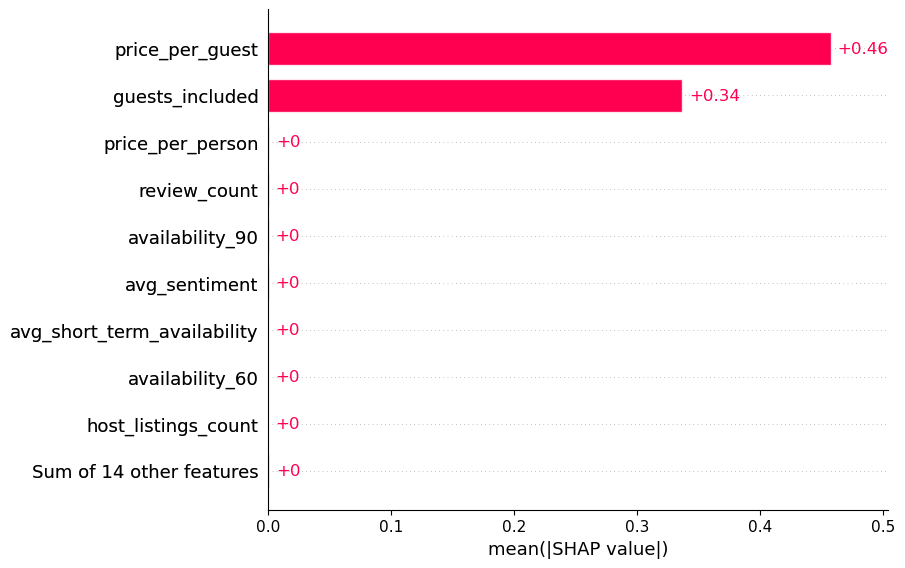

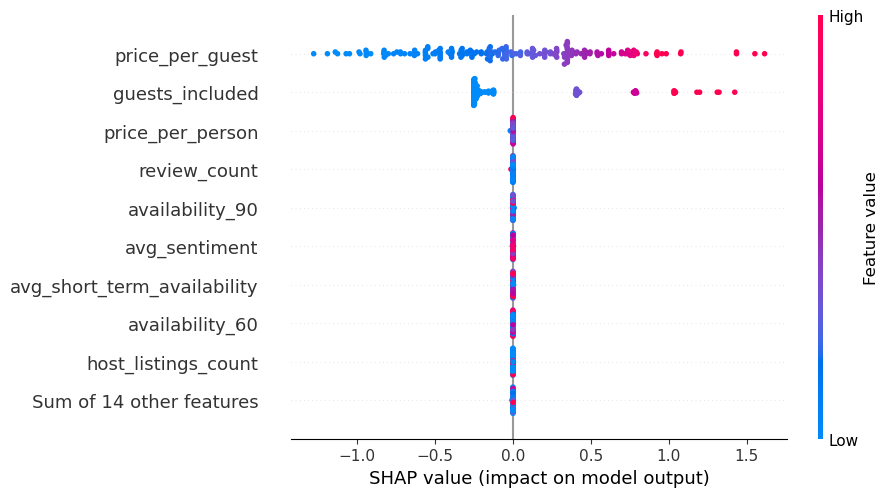

In [13]:
X_sample = X_test.sample(n=200, random_state=42)

explainer = shap.Explainer(model.predict, X_sample)
shap_values = explainer(X_sample)

shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

Insights:

The SHAP Bar plot shows average importance of each feature across all predictions
- price_per_guest and guests_included are the dominant drivers of price.
- avg_sentiment and review_count appear at the bottom with very low SHAP value, meaning they have minimal direct impact on prediction magnitude.
- Most other features are contributing near zero.

The SHAP Beeswarm plot shows how individual feature values push predictions up or down:

- The vertical spread near zero for avg_sentiment and review_count confirms:
  - Their impact is small on model output.
  - They do not strongly sway the prediction, positively or negatively.
- This is consistent with the earlier finding that review features slightly improve RMSE but aren't top predictors.

Conclusion:

- Sentiment and review count are not noise, but they have minor impact compared to engineered pricing and availability features.
- Including them slightly improves RMSE (~0.20), which supports keeping them, but they are not dominant drivers.

### Saving the dataset and the model

In [14]:
df_nlp.to_csv("../outputs/final_price_prediction_data.csv", index=False)
print("Saved dataset as final_price_prediction_data.csv")

with open("../models/final_price_prediction_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Saved model as final_price_prediction_model.pkl")

Saved dataset as final_price_prediction_data.csv
Saved model as final_price_prediction_model.pkl
